## JAX Setup
Code adapted from [JAX examples](https://github.com/google/jax/blob/master/examples/mnist_classifier.py).

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import itertools

import numpy.random as npr

import jax.numpy as np
from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, BatchNorm
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


# used for tensorflow datasets
import tensorflow as tf
tf.enable_eager_execution()

## MNIST Setup

In [14]:
rng = random.PRNGKey(0)

step_size = 0.001
num_epochs = 3
batch_size = 128
momentum_mass = 0.9

NUM_CLASSES = 10

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]')

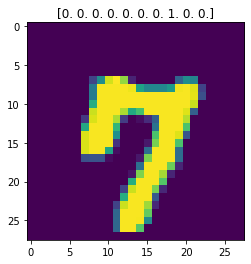

In [15]:
#load mnist
train_ds = tfds.load("mnist", split=tfds.Split.TRAIN, batch_size=-1)
numpy_ds = tfds.as_numpy(train_ds)
numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]
numpy_images.shape, numpy_labels.shape
train_images = numpy_images[:,:,:,0].reshape(-1, 28*28).astype(np.float32)/255.0
train_labels = np.eye(NUM_CLASSES)[numpy_labels]


test_ds = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
numpy_ds = tfds.as_numpy(test_ds)
numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]
numpy_images.shape, numpy_labels.shape
test_images = numpy_images[:,:,:,0].reshape(-1, 28*28).astype(np.float32)/255.0
test_labels = np.eye(NUM_CLASSES)[numpy_labels]
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

plt.imshow(train_images[0].reshape(28,28))
plt.title(str(train_labels[0]))

In [16]:
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

In [17]:
def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

batches = data_stream()

In [18]:
init_random_params, predict = stax.serial(
    Dense(1024), Relu,
    Dense(1024), Relu,
    Dense(10), LogSoftmax)

In [19]:
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -np.mean(preds * targets)

def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

In [20]:
import jax.tree_util as tu

In [21]:
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

_, init_params = init_random_params(rng, (-1, 28 * 28))

# scale params to make spectrum more interesting
init_params = tu.tree_map(lambda x: x*10, init_params)

opt_state = opt_init(init_params)
itercount = itertools.count()

## Train MNIST Regularly

In [22]:
print("\nStarting training...")
for epoch in range(num_epochs):
  start_time = time.time()
  for _ in range(num_batches):
    opt_state = update(next(itercount), opt_state, next(batches))
  epoch_time = time.time() - start_time

  params = get_params(opt_state)
  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))


Starting training...
Epoch 0 in 5.11 sec
Training set accuracy 0.6511833071708679
Test set accuracy 0.6538000106811523
Epoch 1 in 1.08 sec
Training set accuracy 0.7442499995231628
Test set accuracy 0.7440000176429749
Epoch 2 in 1.13 sec
Training set accuracy 0.7870166897773743
Test set accuracy 0.7904000282287598


## MNIST Hessian Spectrum

In [23]:
import matplotlib.pyplot as plt

import density as density_lib
import lanczos as lanczos
import hessian_computation as hessian_computation

In [24]:
# make a generator that yields 1/10th and epoch
batches_list = [next(batches) for i in range(num_batches // 10)]
def batches_fn():
  for b in batches_list:
    yield b

In [25]:
# Hessian-vector product function + Lanczos 
order = 90
hvp, unravel, num_params = hessian_computation.get_hvp_fn(loss, params, batches_fn)
hvp_cl = lambda v: hvp(params, v) / len(batches_list) # Match the API required by lanczos_alg

In [26]:
print("num_params: {}".format(num_params))
start = time.clock()
hvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.clock()
print("hvp compile time: {}".format(end-start))
start = time.clock()
hvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.clock()
print("hvp compute time: {}".format(end-start))

num_params: 1863690
hvp compile time: 1.7144689999999514
hvp compute time: 1.2833929999999896


In [27]:
rng, split = random.split(rng)
start = time.clock()
tridiag, vecs = lanczos.lanczos_alg(hvp_cl, num_params, order, split)
end = time.clock()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=1e-5)

Lanczos time: 556.052651


In [30]:
def plot(grids, density, label=None):
  plt.semilogy(grids, density, label=label)
  plt.ylim(1e-10, 1e2)
  plt.ylabel("Density")
  plt.xlabel("Eigenvalue")
  plt.legend()

W0627 14:10:54.484232 140390849402688 legend.py:1282] No handles with labels found to put in legend.


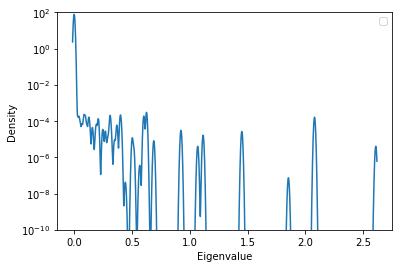

In [31]:
plot(grids, density) # 30 epochs no BN